## Get all the necessary libraries: tensorflow, TFQ, Cirq, matplotlib, sympy and numpy

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq 

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

np.random.seed(1234)

2023-05-15 14:21:26.096639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-15 14:21:26.097571: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-15 14:21:29.861301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-15 14:21:29.861710: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-15 14:21:29.862317: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (C3PO): /proc/driver/nvidia/version does not exist
2023-05-15 14:21:29.869584: I tensorflow/core/platform/cpu_feature_guard

# This is the class that is doing the majority of work in the extension part of the project. I have a VQE class that sets up the circuit ansatz, model and trains the model using gradient descent with Tensorflow-Quantum

In [17]:
class VQE:
  '''
      Class defines the Variational Quantum Eigensolver model and solver.
      The methods allow for the creation of the circuit ansatz, making the
      vqe TF model, and then optimize the parameters against a target Hamiltonian
      to obtain the ground state and ground state energy.
  '''
  def __init__(self, n=4, d=2, J=1, theta=0):
    super(VQE, self).__init__()

    self.nQubits = n
    self.nLayers = d
    #self.nTrott = 3
    self.theta = theta

    self.J = J
    self.B = 1
    
    self.qreg = cirq.LineQubit.range(self.nQubits)

  def get_ansatz(self, qubits, layers, parameters):
    circuit = cirq.Circuit()
    for qubit in qubits:
        circuit += cirq.ry(np.pi / 4.0)(qubit)

    numQubits = len(qubits)
    
    for d in range(layers):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            random_n = np.random.uniform()            
            rot = symbol[d*numQubits + i]
            
            if random_n > 2. / 3.:
                # Add a Z.
                circuit += cirq.rz(rot)(qubit)
            elif random_n > 1. / 3.:
                # Add a Y.
                circuit += cirq.ry(rot)(qubit)
            else:
                # Add a X.
                circuit += cirq.rx(rot)(qubit)

        # Add CZ ladder.
        for src, dest in zip(qubits, qubits[1:]):
            circuit += cirq.CZ(src, dest)
    
    return circuit

  def make_vqe(self, qubits, layers, hamiltonian, magnetization):
    num_params = layers * len(qubits)
    params = sympy.symbols('vqe0:%d'%num_params) # The variational parameters
    c = self.get_ansatz(qubits, layers, params) # Create the circuit

    print(c)

    ins = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string) # Quantum circuits are serialized as strings in TFQ
    pqc = tfq.layers.PQC(c, [hamiltonian, magnetization], differentiator=tfq.differentiators.Adjoint())(ins)
    vqe = tf.keras.models.Model(inputs=ins, outputs=pqc)
    return vqe

  def optimize_vqe_gradient(self, vqe, init):
    old = np.inf
    inputs = tfq.convert_to_tensor([cirq.Circuit()]) # Empty circuit input
    counter = 0 
    vqe.set_weights([init])
    opt = tf.keras.optimizers.Adam(learning_rate=0.1) # Optimizer
    #energy = 0
    
    gradsList = []
    energyList = []

    while counter < 50: # 200 iterations
        with tf.GradientTape() as tape:
            guess = vqe(inputs)[0][0]
        # Get and apply the gradients
        grads = tape.gradient(guess, vqe.trainable_variables) 
        opt.apply_gradients(zip(grads, vqe.trainable_variables))
        guess = guess.numpy()
        #energy = guess
        # If it has reached the minimum, stop optimization
        if abs(guess - old) < 1e-5:
            break
        old = guess
        counter += 1
                
        gradsList.append( grads[0].numpy()[0] )        
        energyList.append( guess )

    #vqe.summary()
    energyList = np.array(energyList)
    gradsList = np.array(gradsList)

    return vqe(inputs)[0][0].numpy(), vqe(inputs)[0][1].numpy(), energyList, np.mean(gradsList), np.var(gradsList)

  def train(self):
    # Create VQE models
    vqe = self.make_vqe(self.qreg, self.nLayers, self.get_hamiltonian(), self.get_magnetization()) 

    initial_value = tf.random.uniform(shape=[self.nLayers * self.nQubits], minval=0, maxval=2 * np.pi)
    # Optimize both models using same random initialization
    ground_gradient, magnetization, energies, gradMean, gradVar = self.optimize_vqe_gradient(vqe, initial_value)

    return ground_gradient, magnetization, energies, gradMean, gradVar

  def get_hamiltonian(self):
    # spin chain
    single = []
    double = []
    
    for i in range(0, self.nQubits - 1):
      double.append( cirq.X(self.qreg[i])*cirq.X(self.qreg[i+1]) )
      double.append( cirq.Y(self.qreg[i])*cirq.Y(self.qreg[i+1]) )
      double.append( cirq.Z(self.qreg[i])*cirq.Z(self.qreg[i+1]) )

    for i in range(self.nQubits):
      single.append( cirq.Z(self.qreg[i]) )

    hamiltonian = (self.J*sum(double) + self.B*sum(single))/self.nQubits

    return hamiltonian

  def get_magnetization(self):

    single = []
    for i in range(self.nQubits):
      single.append( cirq.Z(self.qreg[i]) )

    magnetization = sum(single)

    return magnetization


In [3]:
def process_batch(circuits, symbol, op):
    """Compute the variance of a batch of expectations w.r.t. op on each circuit that 
    contains `symbol`. Note that this method sets up a new compute graph every time it is
    called so it isn't as performant as possible."""
    
    numParameters = len(symbol)

    # Setup a simple layer to batch compute the expectation gradients.
    expectation = tfq.layers.Expectation()

    # Prep the inputs as tensors
    circuit_tensor = tfq.convert_to_tensor(circuits)
    values_tensor = tf.convert_to_tensor(
        np.random.uniform(0, 2 * np.pi, (n_circuits, numParameters)).astype(np.float32))
    
    # Use TensorFlow GradientTape to track gradients.
    with tf.GradientTape() as g:
        g.watch(values_tensor)
        forward = expectation(circuit_tensor,
                              operators=op,
                              symbol_names=symbol,
                              symbol_values=values_tensor)

    # Return variance of gradients across all circuits.
    grads = g.gradient(forward, values_tensor)
    grad_mean = tf.math.reduce_mean(grads, axis=0)
    grad_var = tf.math.reduce_std(grads, axis=0)
    
    #print("grads ", grads)
    #print("grad_var ", grad_var)
    
    return grad_mean.numpy()[0], grad_var.numpy()[0]


In [11]:
def create_ansatz_McClean(qubits, symbol, depth):
    '''
        Quantum circuit ansatz from McClean et al.
        Alternating layers of a randomly chosen rotation along (X,Y,Z) and CNOT ladders
        Each layer has one parameter per qubit for simplified accounting of parameters
        Each parameter rotates the given qubit across a random axis (X,Y,Z)
    '''
    circuit = cirq.Circuit()
    for qubit in qubits:
        circuit += cirq.ry(np.pi / 4.0)(qubit)

    numQubits = len(qubits)
    
    for d in range(depth):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            random_n = np.random.uniform()
            #rot = np.random.uniform(
            #) * 2.0 * np.pi if i != 0 or d != 0 else symbol
            
            rot = symbol[d*numQubits + i]
            
            if random_n > 2. / 3.:
                # Add a Z.
                circuit += cirq.rz(rot)(qubit)
            elif random_n > 1. / 3.:
                # Add a Y.
                circuit += cirq.ry(rot)(qubit)
            else:
                # Add a X.
                circuit += cirq.rx(rot)(qubit)

        # Add CZ ladder.
        for src, dest in zip(qubits, qubits[1:]):
            circuit += cirq.CZ(src, dest)

    return circuit

In [13]:
def get_op(qubits):
    '''
        Spin Chain Hamiltonian with nearest neighbor interaction
        Rescaled by the number of qubits for better comparisons
        Therefore for a spin chain with no interaction and N qubits,
        the lowest energy is -1.0 a.u.
    '''
    single = []
    double = []
    
    nQubits = len(qubits)
    J = 0.5
    B = 1
    
    for i in range(0, nQubits - 1):
      double.append( cirq.X(qubits[i])*cirq.X(qubits[i+1]) )
      double.append( cirq.Y(qubits[i])*cirq.Y(qubits[i+1]) )
      double.append( cirq.Z(qubits[i])*cirq.Z(qubits[i+1]) )

    for i in range(nQubits):
      single.append( cirq.Z(qubits[i]) )

    hamiltonian = (J*sum(double) + B*sum(single))/nQubits

    return hamiltonian

In [18]:
n_qubits = [2 * i for i in range(2, 7)
           ]  # Ranges studied in paper are between 2 and 24.
depth = 50  # Ranges studied in paper are between 50 and 500.
n_circuits = 100
theta_mean = []
theta_var = []

for n in n_qubits:
  # Generate the random circuits and observable for the given n.
  qubits = cirq.GridQubit.rect(1, n)
  num_params = depth * n
  symbol = sympy.symbols('vqe0:%d'%num_params) # The variational parameters
  #symbol = sympy.Symbol('theta')
  circuits = [
      generate_random_qnn(qubits, symbol, depth) for _ in range(n_circuits)
  ]
  #op = cirq.Z(qubits[0]) * cirq.Z(qubits[1])

  op = get_op(qubits)

  tmp = process_batch(circuits, symbol, op)
  theta_mean.append( tmp[0] )
  theta_var.append( tmp[1] )


KeyboardInterrupt: 

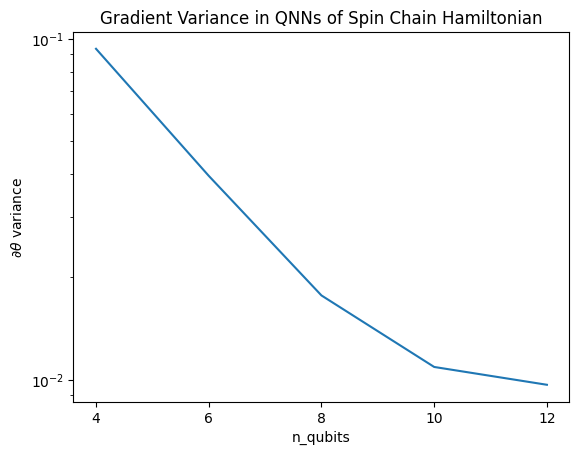

In [7]:
plt.semilogy(n_qubits, theta_var)
plt.title('Gradient Variance in QNNs of Spin Chain Hamiltonian')
plt.xlabel('n_qubits')
plt.xticks(n_qubits)
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

Gradient mean of first parameter  0.0013755364
Gradient variance of first parameter  0.0039352537


Text(0.5, 0, 'Iterations')

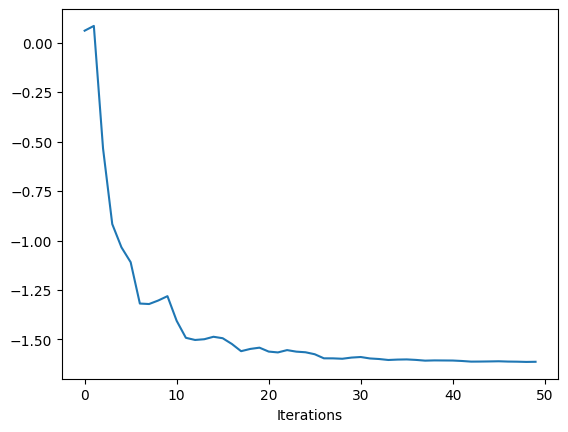

In [9]:
myVQE = VQE(d=50)
_, _, energies, gradMean, gradVar = myVQE.train()

iterations = np.arange(len(energies))


Gradient mean of first parameter  0.0013755364
Gradient variance of first parameter  0.0039352537


(0.0, 50.0)

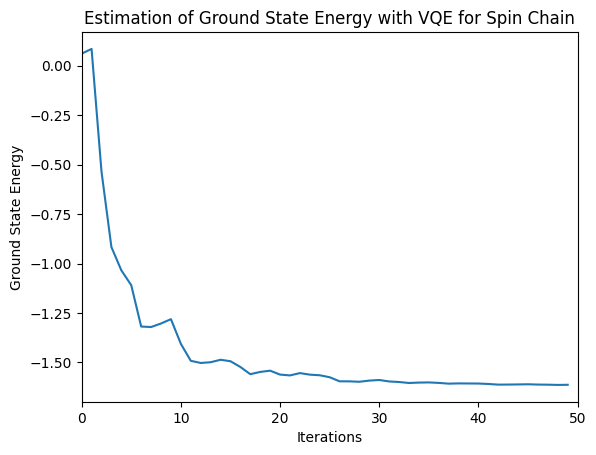

In [16]:
print("Gradient mean of first parameter ", gradMean)
print("Gradient variance of first parameter ", gradVar)

plt.plot(iterations, energies)
plt.xlabel("Iterations")
plt.ylabel("Ground State Energy")
plt.title("Estimation of Ground State Energy with VQE for Spin Chain")
plt.xlim(0,50)

Gradient mean of first parameter  9.247385e-05
Gradient variance of first parameter  0.00030193292


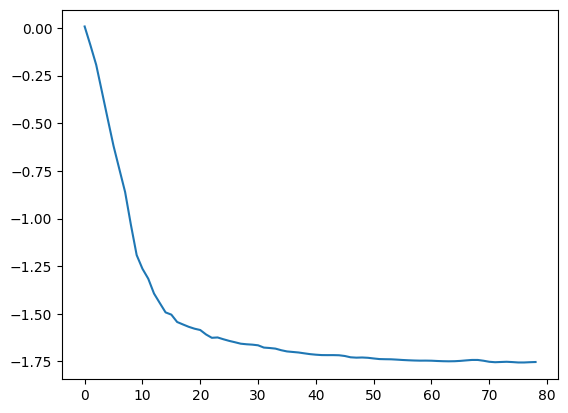

In [134]:
myVQE = VQE(d=50, n = 12)
_, _, energies, gradMean, gradVar = myVQE.train()

iterations = np.arange(len(energies))

print("Gradient mean of first parameter ", gradMean)
print("Gradient variance of first parameter ", gradVar)

plt.plot(iterations, energies)
plt.xlabel("Iterations")